
We have a string : "안녕하세요 👋 (hello in Korean!)" and we want to feed into our language models.

To feed the text to our language models, we have to tokenize the strings, and represent them in some form of integers. These integers will be mapped to vectors in a lookup table and then these vectors will be fed into the models.

So what is this text in Python?

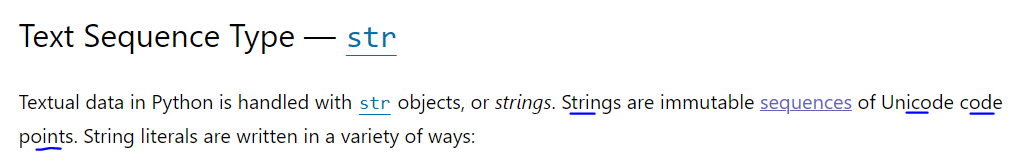

[Python documentation](https://docs.python.org/3/library/stdtypes.html#textseq:~:text=floating%20point%20applications.-,Text,-Sequence%20Type%20%E2%80%94)

**Unicode code points** are unique numerical values assigned to each character in the Unicode standard, representing text in computers.

[Unicode](https://en.wikipedia.org/wiki/Unicode), formally The Unicode Standard, is a text encoding standard maintained by the Unicode Consortium designed to support the use of text in all of the world's writing systems that can be digitized. Version 15.1 of the standard defines 149813 characters and 161 scripts used in various ordinary, literary, academic, and technical contexts.


In [ ]:
[ord(x)for x in "안녕하세요 👋 (hello in Korean!)"]

[50504,
 45397,
 54616,
 49464,
 50836,
 32,
 128075,
 32,
 40,
 104,
 101,
 108,
 108,
 111,
 32,
 105,
 110,
 32,
 75,
 111,
 114,
 101,
 97,
 110,
 33,
 41]

**The Question is why can't we use these integers code points, and not have tokenization at all?**

1. The vocabulary will be quite long (approx. 150k characters as of now)
2. The Unicode standard is continuously evolving, with new characters added regularly.

That means we need a better representation and for that we turn to encodings.

Unicode text is processed and stored as binary data using one of several encodings, which define how to translate the standard's abstracted codes for characters into sequences of bytes. The Unicode Standard itself defines three encodings: UTF-8, UTF-16, and UTF-32, though several others exist. Of these, UTF-8 is the most widely used by a large margin, in part due to its backwards-compatibility with ASCII.

**Question: If Unicode code points undergo changes, wouldn't encodings also need to change since they are conversions of Unicode code points? I don't see how using encodings is advantageous over using Unicode code points directly.**

**Answer:** Using encodings like UTF-8 provides a stable and efficient way to handle text, regardless of changes in the Unicode standard. The encoding mechanisms themselves are fixed and do not change with the addition of new Unicode characters, ensuring consistent representation and processing of text. This stability and efficiency are crucial for language models, making encodings a better choice than using raw Unicode code points directly.

**Question: Why can't we feed these raw bytes as input to the language model?**

**Answer:**
* Feeding bytes directly from UTF-8 would require the model to handle a massive vocabulary size, potentially comprising tens of thousands to millions of tokens (bytes).
* Storing and processing such a vast vocabulary would be computationally expensive and inefficient, impacting both training time and model performance.

**Solution:** Byte-Pair Encoding (BPE) is beneficial for tokenization because it reduces the token sequence, improves model efficiency, and enhances the model's ability to generalize and understand text.

# **Byte-Pair Encoding**

BPE is a word segmentation algorithm that merges the most frequently occurring character or character sequences iteratively.

An extension of the original BPE, Byte-Level BPE operates on a byte-level rather than character-level. It encodes each token as a sequence of bytes rather than characters.
Byte-Level BPE is used by models like GPT-2 for text generation.

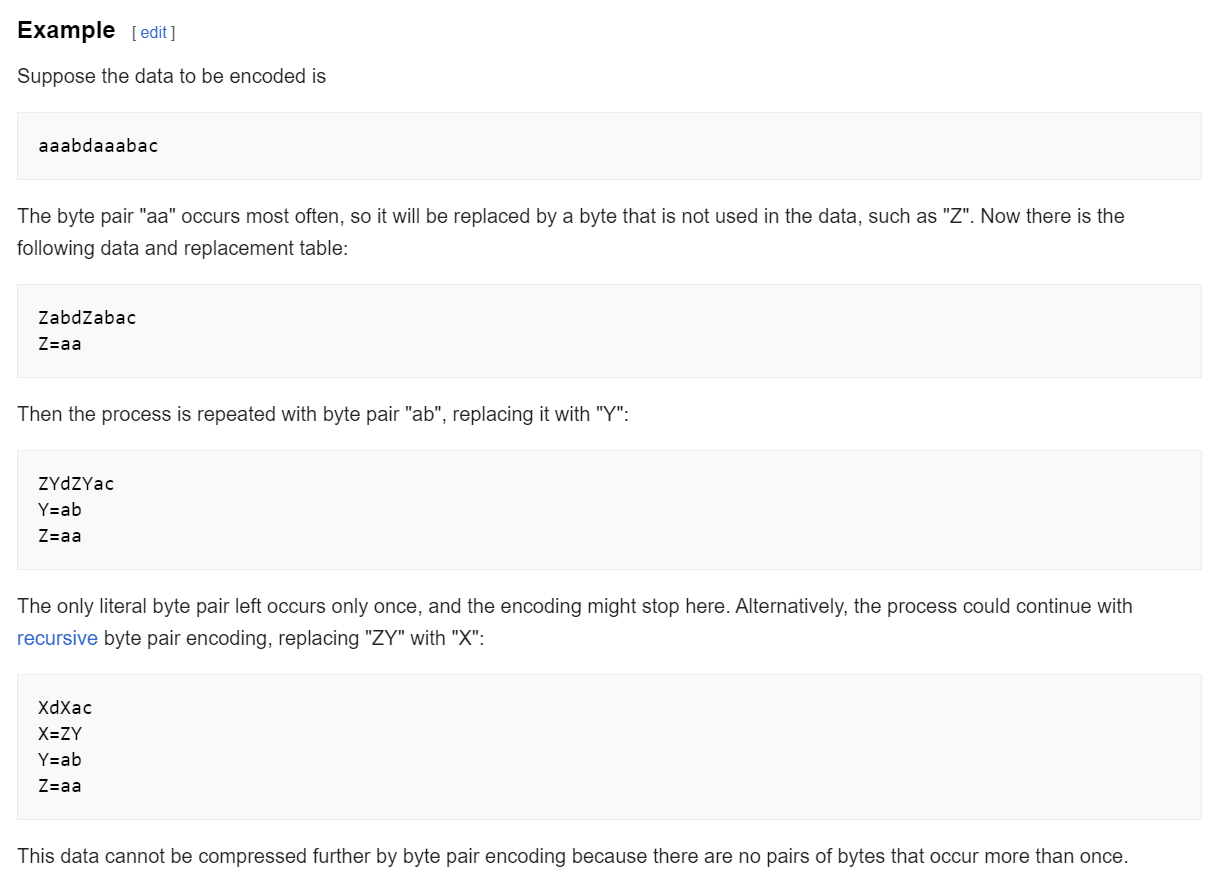

## **Let the coding begin!**

In [ ]:
text="hello"
tokens=text.encode("utf-8")
print(list(tokens))

[104, 101, 108, 108, 111]


In [1]:
import textwrap
#Lets take some text: from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = "Entrepreneurship is the creation or extraction of economic value in ways that generally entail beyond the minimal amount of risk (assumed by a traditional business), and potentially involving values besides simply economic ones."
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience
print('---')
print("\n".join(textwrap.wrap(text, width=100)))
print("length:", len(text))
print('---')
token_strings = [str(token) for token in tokens]
print("\n".join(textwrap.wrap(" ".join(token_strings), width=100)))
print("length:", len(tokens))
# The reason length of tokens is more than text is that, some characters become single byte, and some complex characters become multiple bytes.

---
Entrepreneurship is the creation or extraction of economic value in ways that generally entail
beyond the minimal amount of risk (assumed by a traditional business), and potentially involving
values besides simply economic ones.
length: 228
---
69 110 116 114 101 112 114 101 110 101 117 114 115 104 105 112 32 105 115 32 116 104 101 32 99 114
101 97 116 105 111 110 32 111 114 32 101 120 116 114 97 99 116 105 111 110 32 111 102 32 101 99 111
110 111 109 105 99 32 118 97 108 117 101 32 105 110 32 119 97 121 115 32 116 104 97 116 32 103 101
110 101 114 97 108 108 121 32 101 110 116 97 105 108 32 98 101 121 111 110 100 32 116 104 101 32 109
105 110 105 109 97 108 32 97 109 111 117 110 116 32 111 102 32 114 105 115 107 32 40 97 115 115 117
109 101 100 32 98 121 32 97 32 116 114 97 100 105 116 105 111 110 97 108 32 98 117 115 105 110 101
115 115 41 44 32 97 110 100 32 112 111 116 101 110 116 105 97 108 108 121 32 105 110 118 111 108 118
105 110 103 32 118 97 108 117 101 115 32 98 101 115 

In [2]:
#The get_stats function calculates the frequency of consecutive pairs of elements in a list (ids).
def get_stats(ids):
    counts = {} # Initializes an empty dictionary counts to store frequencies of pairs.
    for pair in zip(ids, ids[1:]): # Pythonic way to iterate consecutive elements. zip(ids, ids[1:]): This creates an iterator that yields tuples of consecutive elements from ids. For example, if ids = [1, 2, 3, 4], zip(ids, ids[1:]) yields [(1, 2), (2, 3), (3, 4)]
        counts[pair] = counts.get(pair, 0) + 1  #counts.get(pair, 0): Retrieves the current count of pair from counts. If pair is not in counts, it defaults to 0.
                                                # counts[pair] = counts.get(pair, 0) + 1: Increments the count of pair by 1 in counts.
    return counts

stats = get_stats(tokens)
print(stats)

{(69, 110): 1, (110, 116): 4, (116, 114): 3, (114, 101): 3, (101, 112): 1, (112, 114): 1, (101, 110): 4, (110, 101): 4, (101, 117): 1, (117, 114): 1, (114, 115): 1, (115, 104): 1, (104, 105): 1, (105, 112): 1, (112, 32): 1, (32, 105): 3, (105, 115): 2, (115, 32): 4, (32, 116): 4, (116, 104): 3, (104, 101): 2, (101, 32): 3, (32, 99): 1, (99, 114): 1, (101, 97): 1, (97, 116): 2, (116, 105): 4, (105, 111): 3, (111, 110): 7, (110, 32): 3, (32, 111): 4, (111, 114): 1, (114, 32): 1, (32, 101): 4, (101, 120): 1, (120, 116): 1, (114, 97): 3, (97, 99): 1, (99, 116): 1, (111, 102): 2, (102, 32): 2, (101, 99): 2, (99, 111): 2, (110, 111): 2, (111, 109): 2, (109, 105): 3, (105, 99): 2, (99, 32): 2, (32, 118): 2, (118, 97): 2, (97, 108): 6, (108, 117): 2, (117, 101): 2, (105, 110): 5, (32, 119): 1, (119, 97): 1, (97, 121): 1, (121, 115): 1, (104, 97): 1, (116, 32): 2, (32, 103): 1, (103, 101): 1, (101, 114): 1, (108, 108): 2, (108, 121): 3, (121, 32): 4, (116, 97): 1, (97, 105): 1, (105, 108): 1, (

In [3]:
print(sorted(((v,k) for k,v in stats.items()), reverse=True))
#sorts the key-value pairs (v as value and k as key) from the dictionary stats in descending order based on values (v).

[(7, (111, 110)), (6, (97, 108)), (5, (105, 110)), (5, (101, 115)), (4, (121, 32)), (4, (116, 105)), (4, (115, 32)), (4, (110, 116)), (4, (110, 101)), (4, (101, 110)), (4, (32, 116)), (4, (32, 111)), (4, (32, 101)), (4, (32, 98)), (3, (116, 114)), (3, (116, 104)), (3, (115, 105)), (3, (114, 101)), (3, (114, 97)), (3, (110, 32)), (3, (109, 105)), (3, (108, 121)), (3, (108, 32)), (3, (105, 111)), (3, (101, 32)), (3, (100, 32)), (3, (32, 105)), (3, (32, 97)), (2, (118, 97)), (2, (117, 101)), (2, (116, 32)), (2, (115, 115)), (2, (111, 109)), (2, (111, 102)), (2, (110, 111)), (2, (110, 100)), (2, (108, 117)), (2, (108, 108)), (2, (105, 115)), (2, (105, 109)), (2, (105, 99)), (2, (104, 101)), (2, (102, 32)), (2, (101, 99)), (2, (99, 111)), (2, (99, 32)), (2, (98, 101)), (2, (97, 116)), (2, (32, 118)), (1, (121, 115)), (1, (121, 111)), (1, (120, 116)), (1, (119, 97)), (1, (118, 111)), (1, (118, 105)), (1, (117, 115)), (1, (117, 114)), (1, (117, 110)), (1, (117, 109)), (1, (116, 101)), (1, (11

In [4]:
chr(111), chr (110)

('o', 'n')

Next, we merge the most frequent pair of tokens and replace them with a new token.

In this case, the most frequent pair (101, 32) will be replaced with a new token 256, since we are already using tokens 0-255 from UTF-8 encoding.

Lets code it.

In [5]:
top_pair = max(stats, key=stats.get)
top_pair

# max(stats, key=stats.get) iterates over the keys of the dictionary stats.
# For each key, it uses stats.get to retrieve the corresponding value.
# It then compares these values to find the maximum value and returns the key associated with this maximum value.

(111, 110)

In [6]:
def merge(ids, pair, idx):
  # in the list of ints (ids), replace all consecutive occurences of pair with the new token idx
  newids = []
  i = 0
  while i < len(ids):
    # if we are not at the very last position AND the pair matches, replace it
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids

# print(merge([5, 6, 6, 7, 9, 1], (6, 7), 99))

tokens2 = merge(tokens, top_pair, 256)
print(tokens2)
print("length:", len(tokens2))

[69, 110, 116, 114, 101, 112, 114, 101, 110, 101, 117, 114, 115, 104, 105, 112, 32, 105, 115, 32, 116, 104, 101, 32, 99, 114, 101, 97, 116, 105, 256, 32, 111, 114, 32, 101, 120, 116, 114, 97, 99, 116, 105, 256, 32, 111, 102, 32, 101, 99, 256, 111, 109, 105, 99, 32, 118, 97, 108, 117, 101, 32, 105, 110, 32, 119, 97, 121, 115, 32, 116, 104, 97, 116, 32, 103, 101, 110, 101, 114, 97, 108, 108, 121, 32, 101, 110, 116, 97, 105, 108, 32, 98, 101, 121, 256, 100, 32, 116, 104, 101, 32, 109, 105, 110, 105, 109, 97, 108, 32, 97, 109, 111, 117, 110, 116, 32, 111, 102, 32, 114, 105, 115, 107, 32, 40, 97, 115, 115, 117, 109, 101, 100, 32, 98, 121, 32, 97, 32, 116, 114, 97, 100, 105, 116, 105, 256, 97, 108, 32, 98, 117, 115, 105, 110, 101, 115, 115, 41, 44, 32, 97, 110, 100, 32, 112, 111, 116, 101, 110, 116, 105, 97, 108, 108, 121, 32, 105, 110, 118, 111, 108, 118, 105, 110, 103, 32, 118, 97, 108, 117, 101, 115, 32, 98, 101, 115, 105, 100, 101, 115, 32, 115, 105, 109, 112, 108, 121, 32, 101, 99, 256,

**Now, let's generalize the code to handle a longer input text.**



In [7]:
# making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-unicode/
text = """What are the 4 Types of Entrepreneurship?
It is classified into the following types:

Small Business Entrepreneurship-

These businesses are a hairdresser, grocery store, travel agent, consultant, carpenter, plumber, electrician, etc. These people run or own their own business and hire family members or local employee. For them, the profit would be able to feed their family and not making 100 million business or taking over an industry. They fund their business by taking small business loans or loans from friends and family.

Scalable Startup Entrepreneurship-

This start-up entrepreneur starts a business knowing that their vision can change the world. They attract investors who think and encourage people who think out of the box. The research focuses on a scalable business and experimental models, so, they hire the best and the brightest employees. They require more venture capital to fuel and back their project or business.

Large Company Entrepreneurship-

These huge companies have defined life-cycle. Most of these companies grow and sustain by offering new and innovative products that revolve around their main products. The change in technology, customer preferences, new competition, etc., build pressure for large companies to create an innovative product and sell it to the new set of customers in the new market. To cope with the rapid technological changes, the existing organisations either buy innovation enterprises or attempt to construct the product internally.

Social Entrepreneurship-

This type of entrepreneurship focuses on producing product and services that resolve social needs and problems. Their only motto and goal is to work for society and not make any profits.

Characteristics of Entrepreneurship:
Not all entrepreneurs are successful; there are definite characteristics that make entrepreneurship successful. A few of them are mentioned below:

Ability to take a risk- Starting any new venture involves a considerable amount of failure risk. Therefore, an entrepreneur needs to be courageous and able to evaluate and take risks, which is an essential part of being an entrepreneur.
Innovation- It should be highly innovative to generate new ideas, start a company and earn profits out of it. Change can be the launching of a new product that is new to the market or a process that does the same thing but in a more efficient and economical way.
Visionary and Leadership quality- To be successful, the entrepreneur should have a clear vision of his new venture. However, to turn the idea into reality, a lot of resources and employees are required. Here, leadership quality is paramount because leaders impart and guide their employees towards the right path of success.
Open-Minded- In a business, every circumstance can be an opportunity and used for the benefit of a company. For example, Paytm recognised the gravity of demonetization and acknowledged the need for online transactions would be more, so it utilised the situation and expanded massively during this time.
Flexible- An entrepreneur should be flexible and open to change according to the situation. To be on the top, a businessperson should be equipped to embrace change in a product and service, as and when needed.
Know your Product-A company owner should know the product offerings and also be aware of the latest trend in the market. It is essential to know if the available product or service meets the demands of the current market, or whether it is time to tweak it a little. Being able to be accountable and then alter as needed is a vital part of entrepreneurship. Importance of Entrepreneurship:
Creation of Employment- Entrepreneurship generates employment. It provides an entry-level job, required for gaining experience and training for unskilled workers.
Innovation- It is the hub of innovation that provides new product ventures, market, technology and quality of goods, etc., and increase the standard of living of people.
Impact on Society and Community Development- A society becomes greater if the employment base is large and diversified. It brings about changes in society and promotes facilities like higher expenditure on education, better sanitation, fewer slums, a higher level of homeownership. Therefore, entrepreneurship assists the organisation towards a more stable and high quality of community life.
Increase Standard of Living- Entrepreneurship helps to improve the standard of living of a person by increasing the income. The standard of living means, increase in the consumption of various goods and services by a household for a particular period.
Supports research and development- New products and services need to be researched and tested before launching in the market. Therefore, an entrepreneur also dispenses finance for research and development with research institutions and universities. This promotes research, general construction, and development in the economy."""


In [8]:
tokens = text.encode("utf-8") # raw bytes
tokens = list(map(int, tokens)) # convert to a list of integers in range 0..255 for convenience

In [9]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
  newids = []
  i = 0
  while i < len(ids):
    if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
      newids.append(idx)
      i += 2
    else:
      newids.append(ids[i])
      i += 1
  return newids

# ---
vocab_size = 276 # the desired final vocabulary size
num_merges = vocab_size - 256
ids = list(tokens) # copy so we don't destroy the original list

merges = {} # (int, int) -> int
for i in range(num_merges):
  stats = get_stats(ids)
  pair = max(stats, key=stats.get)
  idx = 256 + i
  print(f"merging {pair} into a new token {idx}")
  ids = merge(ids, pair, idx)
  merges[pair] = idx

merging (101, 32) into a new token 256
merging (32, 116) into a new token 257
merging (97, 110) into a new token 258
merging (114, 101) into a new token 259
merging (105, 110) into a new token 260
merging (115, 32) into a new token 261
merging (100, 32) into a new token 262
merging (257, 104) into a new token 263
merging (116, 32) into a new token 264
merging (97, 114) into a new token 265
merging (101, 114) into a new token 266
merging (101, 110) into a new token 267
merging (111, 110) into a new token 268
merging (258, 262) into a new token 269
merging (111, 102) into a new token 270
merging (110, 101) into a new token 271
merging (101, 115) into a new token 272
merging (44, 32) into a new token 273
merging (263, 256) into a new token 274
merging (121, 32) into a new token 275


In [10]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")

tokens length: 4926
ids length: 3803
compression ratio: 1.30X


Note, the Tokenizer is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

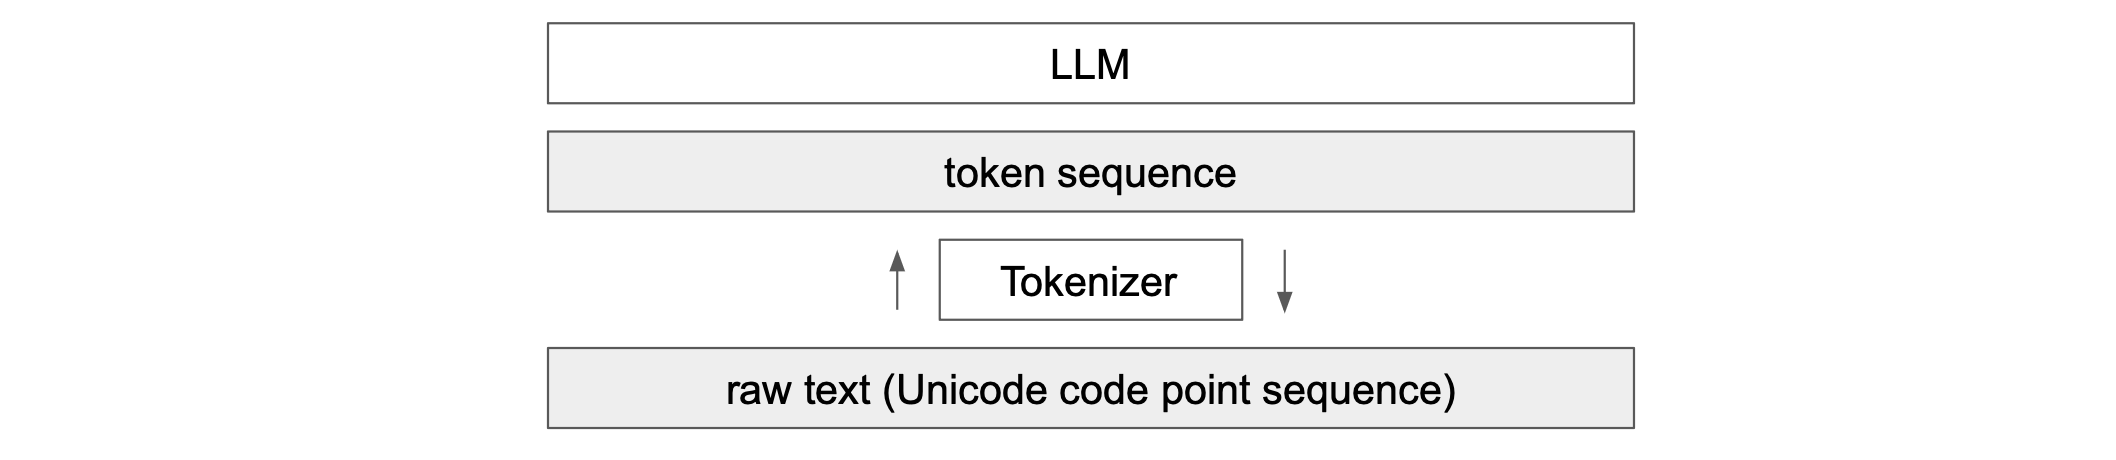

### **Decoding**

Given a sequence of integers in the range [0, vocab_size], what is the text?


In [11]:
#First lets just create a dictionary of integers as keys and their corresponding byte values.
vocab = {idx: bytes([idx]) for idx in range(256)} #This line initializes a dictionary vocab where the keys are integers from 0 to 255
                                                  #(representing the initial byte values from UTF-8 encoding), and the values are the
                                                  #corresponding byte representations.

#Second, update the vocab dictionary with the new merged tokens (their key and corresponding bytes)
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1]

# This loop iterates over the merges dictionary, which contains pairs of tokens (as keys) and their new token indices (as values).
# For each pair (p0, p1), it creates a new entry in vocab where the key is the new token index idx,
# and the value is the concatenation of the byte representations of p0 and p1.
# This step builds up the vocab to include the newly created tokens resulting from the merges.


In [12]:
vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [13]:
def decode(ids):
  # given ids (list of integers), return Python string
  tokens = b"".join(vocab[idx] for idx in ids) #vocab[idx] retrieves the byte representation from the vocab dictionary for each index
                                              #idx in the ids list.
                                              #b"".join(...) concatenates these byte representations (vocab[idx])
                                              #into a single byte string (tokens).
  text = tokens.decode("utf-8", errors="replace")
  return text

print(decode([257,256]))

 te 


### **Encoding**

The other way around: Given a string, what are the tokens?

In [14]:
merges

{(101, 32): 256,
 (32, 116): 257,
 (97, 110): 258,
 (114, 101): 259,
 (105, 110): 260,
 (115, 32): 261,
 (100, 32): 262,
 (257, 104): 263,
 (116, 32): 264,
 (97, 114): 265,
 (101, 114): 266,
 (101, 110): 267,
 (111, 110): 268,
 (258, 262): 269,
 (111, 102): 270,
 (110, 101): 271,
 (101, 115): 272,
 (44, 32): 273,
 (263, 256): 274,
 (121, 32): 275}

In [15]:
len(merges)

20

In [16]:
tokens = list(text.encode("utf-8"))
stats = get_stats(tokens)
print(stats)

{(87, 104): 1, (104, 97): 20, (97, 116): 32, (116, 32): 59, (32, 97): 102, (97, 114): 47, (114, 101): 100, (101, 32): 135, (32, 116): 104, (116, 104): 68, (104, 101): 73, (32, 52): 1, (52, 32): 1, (32, 84): 16, (84, 121): 1, (121, 112): 3, (112, 101): 19, (101, 115): 68, (115, 32): 81, (32, 111): 60, (111, 102): 37, (102, 32): 34, (32, 69): 10, (69, 110): 9, (110, 116): 48, (116, 114): 30, (101, 112): 20, (112, 114): 46, (101, 110): 67, (110, 101): 57, (101, 117): 20, (117, 114): 34, (114, 115): 26, (115, 104): 21, (104, 105): 33, (105, 112): 17, (112, 63): 1, (63, 10): 1, (10, 73): 5, (73, 116): 6, (32, 105): 46, (105, 115): 31, (32, 99): 34, (99, 108): 3, (108, 97): 10, (97, 115): 11, (115, 115): 23, (115, 105): 23, (105, 102): 6, (102, 105): 10, (105, 101): 14, (101, 100): 27, (100, 32): 77, (105, 110): 72, (116, 111): 30, (111, 32): 31, (32, 102): 25, (102, 111): 15, (111, 108): 8, (108, 108): 8, (108, 111): 20, (111, 119): 15, (119, 105): 4, (110, 103): 32, (103, 32): 22, (116, 12

**Example Walkthrough of the encode function:**

Let's go through an example to see how this works in practice. Suppose we have a few keys in stats and see how they would be evaluated:



For a key (101, 32) in stats, the lambda function would look up merges.get((101, 32), float("inf")). According to merges, (101, 32) maps to 256.

For a key (116, 104) in stats, the lambda function would look up merges.get((116, 104), float("inf")). According to merges, (116, 104) maps to 259.

For a key (65, 32) in stats, the lambda function would look up merges.get((65, 32), float("inf")). If (65, 32) is not in merges, it returns float("inf").

Determine the Minimum Key
The min function compares these values:

* (65, 32) -> float("inf")
* (101, 32) -> 256
* (116, 104) -> 259

Among these values, 256 is the smallest. Therefore, the min function would return (101, 32) as the key with the smallest value according to the lambda function.

Summary:

The min function finds the smallest key in stats based on the values obtained from the merges dictionary. If a key is not present in merges, it is assigned a value of float("inf"), which effectively makes it larger than any other value in merges. This allows min to ignore keys that are not in merges and only consider those that are.



In [17]:
def encode(text):
  # given a string, return list of integers (the tokens)
  tokens = list(text.encode("utf-8"))
  while len(tokens) >= 2:
    stats = get_stats(tokens)
    pair = min(stats, key=lambda p: merges.get(p, float("inf")))
    if pair not in merges:
      break # nothing else can be merged
    idx = merges[pair]
    tokens = merge(tokens, pair, idx)
  return tokens

print(encode("hello world"))
# merges: This is a dictionary that maps pairs of tokens (p) to integer indices.
# p: This represents a key (a pair of tokens) that we want to retrieve from the merges dictionary.
# float("inf"): This is a floating-point representation of positive infinity in Python. It's used as a default value in case the key p is not found in the dictionary merges.
# the  min(stats, key=lambda p: merges.get(p, float("inf"))) will then return the pair that hasn't been merged yet
#it will then merge untill it cannot be merged further

[104, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100]


In [18]:
check= decode(encode("hello world"))
print(check)

hello world


**References**

https://colab.research.google.com/drive/1y0KnCFZvGVf_odSfcNAws6kcDD7HsI0L?usp=sharing#scrollTo=xKaWXIaiOhvs

https://youtu.be/zduSFxRajkE?si=F_7SW_x4LnHz0NuH

https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt
https://github.com/google/sentencepiece

https://github.com/openai/tiktoken
